# Project

**Optimizations - Travelling Salesman Problem.**
Perform optimizations to the TSP using 4 meta-heuristic algorithms:
- Hill Climbing
- Simulated Annealing
- Tabu Search
- Genetic Algorithm

A project done as a part of FEUP (**Faculty of Engineering of the University of Porto**) curriculum, Artificial Intelligence bachelor's course (3rd year). 

**Steps:**

0. import data
1.   Define objective function (total time = travel time + waiting time + inspection time)
2.   Generate population (random matrix NPOP x (n+2*k))


*   NPOP= number of individuals in population
*   n=number of establishments
*   k=0,1*n= number of vehicles
*   2*k is added to consider starting and ending point of each vehicle
3. evaluate fitness
* (-)objective function (greatest fit the one with less total time)
4. order population by fitness
5.   select parents
6.   crossover
7. mutation
8. update population
9. evaluate fitness
10. order population by fitness
11. go back to 5 until stopping criteria



# Import Data

Choose one:

Import data from google cloud

In [16]:
# skip if you want to import data locally
import numpy as np
import copy, random, math
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from collections import deque
import time

# importing data from google drive cloud
def import_excel():
  url='https://drive.google.com/file/d/1vu3UhfxA61Ksu3z85LSqKeHusGynPeKn/view?usp=sharing'
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  df = pd.read_csv(url)
  distances = np.array(df.iloc[0:, 0:].values)


  url='https://drive.google.com/file/d/1lsplyuLXJ5W5WELVWlJEP0DiGVCY0faA/view?usp=sharing'
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  df2 = pd.read_csv(url)
  inspection_times=np.array(df2.iloc[:, 8].values) #inspection_times-array with inspection times
  latitudes=np.array(df2.iloc[:, 5].values)
  longitudes=np.array(df2.iloc[:, 6].values)

  column_data = df2.iloc[:, -1]
  data_list = [[int(x) for x in row.strip('][').split(', ')] for row in column_data]
  schedule = np.array(data_list)
  #np.set_printoptions(threshold=np.inf)   # to print ALL the lines
  return distances,inspection_times,schedule, latitudes, longitudes

Or:

Inport data locally

In [24]:
# skip if you want to import data from cloud
import numpy as np
import copy, random, math
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from collections import deque
import time

# importing data locally
# WILL NOT WORK ON GOOGLE COLAB
def import_excel():
    # example path windows
    #file_path=r'C:\Users\user\Desktop\ai\data_ASAE.xlsx'
    # linux
    file_path="/home/david/Desktop/ai/AI-TSP/data_ASAE.xlsx"

    df = pd.read_excel(file_path, sheet_name='distances')
    distances = np.array(df.iloc[1:, 1:].values, dtype=float) #distances-matrix with distances

    df2 = pd.read_excel(file_path, sheet_name='establishments')
    inspection_times=np.array(df2.iloc[:, 8].values) #inspection_times-array with inspection times
    latitudes=np.array(df2.iloc[:, 5].values)
    longitudes=np.array(df2.iloc[:, 6].values)

    # Extract the last column of the DataFrame
    column_data = df2.iloc[:, -1]
    # Convert the column data into a list of lists
    data_list = [[int(x) for x in row.strip('][').split(', ')] for row in column_data]
    # Convert the list of lists into a NumPy array
    schedule = np.array(data_list)
    return distances,inspection_times,schedule, latitudes, longitudes

# Travel time minimization




## Evaluate function

In [25]:
class InspectionRouteProblem:
    def __init__(self, distances, inspection_times, schedule, n):
        num_vehicles=int(n/10)
        self.distances = distances
        self.inspection_times = inspection_times
        self.schedule = schedule
        self.num_vehicles = num_vehicles
        self.num_establishments = 10

    def evaluate_solution(self, individual):
        routes = np.reshape(individual, (self.num_vehicles, self.num_establishments +2))
        previous_time=0
        total_time = 0
        for vehicle in routes: #iterates for each vehicle
            total_time_v = 0
            travel_time = 0
            inspection_time = 0
            current_time = 9   #every route starts at 9 AM
            for i in range(len(vehicle) - 1):
                waiting_time = 0
                start = vehicle[i]
                end = vehicle[i + 1]
                travel_time += self.distances[start][end] / 3600 #time it took to get from establishment start to end, in hours
                inspection_time += self.inspection_times[start] / 60 #time it took to inspect establishment start, in hours
                open_hours = self.schedule[start]
                arrival_time = current_time + travel_time
                if arrival_time >= 24: #checks if the passes midnight
                    arrival_time -= 24
                if open_hours[int(arrival_time)] == 1: #checks if the establishment is open on arrival
                    current_time = arrival_time + self.inspection_times[start] / 60 #updates hour of the day
                else:
                    waiting_time += int(arrival_time) + 1 - arrival_time #process to calculate the waiting time until it opens
                    next_open_time = int(arrival_time) + 1
                    if next_open_time == 24:
                        next_open_time = 0
                    while open_hours[next_open_time] == 0:
                        waiting_time += 1
                        next_open_time += 1
                        if next_open_time == 24:
                          next_open_time = 0
                    current_time = arrival_time + waiting_time + self.inspection_times[start] / 60 #updates hour of the day
            total_time_v += travel_time + inspection_time + waiting_time #total time for this vehicle to inspect 10 establishments
            if total_time_v>previous_time: #updates the longest route
                total_time=total_time_v
            previous_time=total_time_v
        return -total_time

## Auxiliary functions

In [26]:
def get_greatest_fit(population,scores):
    best_solution = population[0]
    best_score = scores[0]
    for i in range(1, len(population)):
        score = scores[i]
        if score > best_score:
            best_score = score
            best_solution = population[i]
    return best_solution, best_score

def ordered_random_two_point_crossover(solution_1, solution_2):
    #Performs ordered random two-point crossover between two solutions
    length = len(solution_1)
    crossover_points = sorted([random.randint(0, length), random.randint(0, length)])
    zeros = [i for i in range(length) if solution_1[i] == 0 or solution_2[i] == 0]
    child_1 = [0] * length
    child_2 = [0] * length

    # First child
    for i in range(crossover_points[0], crossover_points[1]):
        child_1[i] = solution_1[i]
    j = 0
    for i in range(length):
        if solution_2[i] not in child_1 and solution_2[i] != 0:
            if i not in zeros:
                child_1[i] = solution_2[i]
                j += 1
        else:
            child_1[i] = solution_1[i]

    # Second child
    for i in range(crossover_points[0], crossover_points[1]):
        child_2[i] = solution_2[i]
    j = 0
    for i in range(length):
        if solution_1[i] not in child_2 and solution_1[i] != 0:
            if i not in zeros:
                child_2[i] = solution_1[i]
                j += 1
        else:
            child_2[i] = solution_2[i]

    return child_1, child_2

def offspring(parents): #generates offspring through crossover
    num_parents = (len(parents))
    offspring = []
    for i in range(0, num_parents, 2):
        solution_1 = parents[i]
        solution_2 = parents[i+1]
        child_1, child_2 = ordered_random_two_point_crossover(solution_1, solution_2)
        # Convert strings to numpy arrays
        child_1 = np.array([int(digit) for digit in child_1[1:-1]])
        child_2 = np.array([int(digit) for digit in child_2[1:-1]])
        child_1= np.concatenate(([0], child_1, [0]))
        child_2= np.concatenate(([0], child_2, [0]))
        offspring.append(child_1)
        offspring.append(child_2)
    return offspring

def generate_random_solution(n):     #generates a random solution, that consists in one route
    values = np.random.permutation(np.arange(1, n + 1))
    values_with_zeros = []
    count = 0
    for i, val in enumerate(values):
        if count == 10:
            values_with_zeros.extend([0, 0])
            count = 0
        values_with_zeros.append(val)
        count += 1
    if count > 0 and count < 10:
        num_zeros = 10 - count
        values_with_zeros.extend([0] * num_zeros)
    return np.concatenate(([0], values_with_zeros, [0]))

def generate_population(population_size,n):
    solutions = []
    for i in range(population_size):
        solutions.append(generate_random_solution(n))
    return solutions

def print_population(population):
    solutions = []
    for i in range(len(population)):
        print(f"Solution {i}: {population[i]}, {problem.evaluate_solution(population[i])}")
        solutions.append(population[i])
    return np.array(solutions)

def tournament_select(population, tournament_size, scores): #tournament selection
    population_copy = copy.deepcopy(population)
    best_solution = population_copy[0]
    best_score = scores[0]
    for i in range(tournament_size):
        index = np.random.randint(0, len(population_copy))
        score = scores[index]
        if score > best_score:
            best_score = score
            best_solution = population_copy[index]
        del population_copy[index]
    return best_solution

def replace_worst_individuals(population, offspring,scores):
    # sort population by fitness in ascending order

    sorted_indices = np.argsort(scores)
    sorted_population = [population[i] for i in sorted_indices]

    # replace the worst individuals in the sorted population with offspring
    num_offspring = len(offspring)
    for i in range(num_offspring):
        sorted_population[-(i+1)] = offspring[i]

    # return the updated population
    return sorted_population

def roulette_select(population,scores): #roulette selection
    score_sum = np.sum(scores)
    selection_probabilities = scores / score_sum
    return population[np.random.choice(len(population), p=selection_probabilities)]

def roulette_select_pool(population, pool_size, scores): #roulette selection to a pool
    pool = []
    for i in range(pool_size):
        selected_solution = roulette_select(population, scores)
        pool.append(selected_solution)
    return pool

def tournament_select_pool(population, pool_size, tournament_size, scores): #tournament selection to a pool
    pool = []
    for i in range(pool_size):
        selected_solution = tournament_select(population, tournament_size, scores)
        pool.append(selected_solution)
    return pool

def roulette_and_tournament_select_pool(population, pool_size, tourn_p, tournament_size, scores): #combines roulette and tournament selection to a pool
    roulette_size = int(pool_size * (1 - tourn_p))
    tournament_pool_size = int(pool_size * tourn_p)
    pool = roulette_select_pool(population, roulette_size, scores)
    tournament_pool = tournament_select_pool(population, tournament_pool_size, tournament_size, scores)
    pool.extend(tournament_pool)
    return pool

def pool_select_parents(population_size, pool, Pcross):  #selects parents from the pool with Pcross percentage of the population to be chose as parents
    num_parents = int(population_size * Pcross)
    if num_parents % 2 == 1:
      num_parents -= 1
    parent_indices = []
    selected_parents = set()
    while len(selected_parents) < num_parents:
        x = np.random.randint(len(pool))
        individual = tuple(pool[x])
        if individual not in selected_parents:
            selected_parents.add(individual)
            parent_indices.append(x)
    parents = [pool[i] for i in parent_indices]
    return parents

def mutate_solution(solution, problem):
    num_swaps=(problem.num_vehicles)  #makes the number of swaps in mutation be adjusted to the data size
    non_zero_indices = [i for i in range(len(solution)) if solution[i] != 0]
    indices = random.sample(non_zero_indices, num_swaps)
    for i in range(0, len(indices), 2):
        index_1 = indices[i]
        index_2 = indices[i+1]
        solution[index_1], solution[index_2] = solution[index_2], solution[index_1]
    return solution

def mutate_population(population, Pmutate,p_nei, problem,n):
    mutated_population = []
    #numbers = sum(population, [])
    #x=len(numbers)
    #y=int(x/12)
    #routes = np.reshape(population, (y,12))
    for individual in population:
        if np.random.rand() < Pmutate:
            if np.random.rand() <p_nei:    #gives p_nei probability of mutation be performed via local search (two-opt)
              mutated_individual = get_neighbour_solution(individual,problem,n)
            else:
              mutated_individual = mutate_solution(individual,problem)
        else:
            mutated_individual = individual
        mutated_population.append(mutated_individual)
    return mutated_population


def evolve_population(population,population_size, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, scores, problem,n):
    parents = pool_select_parents(population_size, roulette_and_tournament_select_pool(population,pool_size, tourn_p, tournament_size, scores), Pcross)
    offsp = offspring(parents)
    offsp=mutate_population(offsp, Pmutate,p_nei,problem,n)
    population=replace_worst_individuals(population, offsp,scores)
    return population

def get_neighbour_solution(tour, problem,n): #two-opt
    zeros_indices = np.where(tour == 0)[0]  # get the indices of the zeros in the tour
    zeros_positions = zeros_indices.argsort()  # get the positions of the zeros in the tour
    tour_without_zeros = tour[tour != 0]  # remove the zeros from the tour
    best_tour = tour
    best_time = problem.evaluate_solution(tour)
    t = len(tour_without_zeros)
    for i in range(1, t-1, int(n/20)):
        for j in range(i+1, t,int(n/20)):
            new_tour_without_zeros = np.concatenate((tour_without_zeros[:i], tour_without_zeros[i:j+1][::-1], tour_without_zeros[j+1:]))
            count=0
            count_2=0
            new_tour=np.zeros(len(tour))
            for k in range(len(tour)):
                if k != zeros_indices[count]:
                    new_tour[k]=new_tour_without_zeros[count_2]
                    count_2+=1
                else:
                    count+=1
            new_time = problem.evaluate_solution(new_tour.astype(int))
            if new_time > best_time:
                best_tour = new_tour
                best_time = new_time
    return best_tour.astype(int)

def problem(distances, inspection_times, schedule, n):
    problem = InspectionRouteProblem(distances, inspection_times, schedule, n)
    return problem

## Genetic Algorithm

In [27]:
#num_iterations is the max number of iterations without change in the optimal value
#population_size is self explainable
#n is the number of establishments
#Pcross is the percentage of the population we want to select as parents
#pool_size is the size of the pool, in which we put all the contestants to be selected as parents
#tourn_p is the percentage of the pool that is selected via tournament, the rest is with roullete
#tournament_size is how many "battles" I want to do in the tournament
#Pmutate is the probability of mutation
#p_nei is the probability of mutating with local search, via two-opt. It gives a better mutation, but requires more computational effort, therefor for big data sets should be smaller
#--------------------------------------------------------------------------

def genetic_algorithm(num_iterations, population_size, n, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, problem,  log=False):
    start_time = time.time()
    distances,inspection_times,schedule, latitudes, longitudes=import_excel()
    problem=problem(distances, inspection_times, schedule, n)

    population = generate_population(population_size,n)
    #print_population(population)
    best_solution = population[0] # Initial solution
    best_score = problem.evaluate_solution(population[0])
    best_solution_generation = 0 # Generation on which the best solution was found
    iterations=num_iterations #saves the number of executed iterations
    generation_no = 0
    if log:
      print(f"Initial solution: {best_solution}, time to inspect all establishments: {-int(best_score)} h {int((best_score % 1)*60)} min")
    else:
      print(f"Initial solution: Time to inspect all establishments: {-int(best_score)} h {int((best_score % 1)*60)} min")
    best_scores = []
    best_solutions = []
    generations=[]
    while(num_iterations > 0):

        generation_no += 1

        scores = []
        # loop through each individual in the population
        for individual in population:
        # evaluate the individual's solution and append the score to the scores list
          scores.append(problem.evaluate_solution(individual))
        scores = np.array(scores)
        # Next generation
        population=evolve_population(population,population_size, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, scores, problem,n)
        #print(f"population evolved in generation {generation_no}: {population}")
        # Checking the greatest fit among the current population
        greatest_fit, greatest_fit_score = get_greatest_fit(population,scores)
        if greatest_fit_score > best_score:
            best_solution = greatest_fit
            best_score = greatest_fit_score
            best_solution_generation = generation_no
            best_scores.append(-best_score)
            best_solutions.append(best_solution)
            generations.append(generation_no)
            if log:
                print(f"\nGeneration: {generation_no }")
                print(f"Solution: {best_solution}, score: {best_score}")
                #print_population(population)
        else:
            num_iterations -= 1
    end_time = time.time()
    time_running= round(end_time - start_time,3)
    if log:
      print(f"  Final solution: {best_solution}, time to inspect all establishments: {int(abs(best_score))} h {int((abs(best_score) % 1)*60)} min")
    else:
      print(f"  Final solution: Time to inspect all establishments: {int(abs(best_score))} h {int((abs(best_score) % 1)*60)} min")
    print(f"  Found on generation {best_solution_generation}")
    print(f"  Number of vehicles utilized: {int(n/10)}")
    print(f"  Number of inspected economic operators: {n}")
    # plot evolution data
    plt.plot(generations, best_scores)
    plt.xlabel('Generation')
    plt.ylabel('Time to inspect all establishments [h]')
    plt.title('Evolution of Best Solution')
    plt.show()

    #ID list
    vehicles = np.reshape(best_solution, (int(n/10), 12))
    # initialize table with headers
    table= PrettyTable()
    table.field_names = ['Vehicle', 'IDs']
    # iterate over each route in the list of routes
    for i, route in enumerate(vehicles):
      # add row to the table for the current route
      table.add_row([f'Vehicle {i+1}', route])
    # print the table
    print(table)
    print(f"total time spent running the algorithm: {time_running} s")
    print(f"number of iterations to reach the optimal solution: {best_solution_generation}")
    print(f"total number of iterations executed: {best_solution_generation+iterations}")
    return best_solution

### 20 establishments

In [28]:
result_20_establishments = genetic_algorithm(50,30,20,0.6,80,0.5,4,0.4,0.2,problem) #20

Initial solution: Time to inspect all establishments: 20 h 38 min
  Final solution: Time to inspect all establishments: 14 h 55 min
  Found on generation 5
  Number of vehicles utilized: 2
  Number of inspected economic operators: 20
+-----------+---------------------------------------+
|  Vehicle  |                  IDs                  |
+-----------+---------------------------------------+
| Vehicle 1 | [ 0  9  1  9 10 19 16 10 14 20  6  0] |
| Vehicle 2 | [ 0 18 15  5 18  3 17 13  8  5  2  0] |
+-----------+---------------------------------------+
total time spent running the algorithm: 13.003 s
number of iterations to reach the optimal solution: 5
total number of iterations executed: 55


### 100 establishments

In [29]:
result_100_establishments = genetic_algorithm(50,20,100,0.6,120,0.5,10,0.7,0.3,problem)

Initial solution: Time to inspect all establishments: 31 h 56 min
  Final solution: Time to inspect all establishments: 11 h 31 min
  Found on generation 13
  Number of vehicles utilized: 10
  Number of inspected economic operators: 100
+------------+---------------------------------------------------+
|  Vehicle   |                        IDs                        |
+------------+---------------------------------------------------+
| Vehicle 1  |       [ 0 47 93 52 58 36 53  9 92 13 90  0]       |
| Vehicle 2  |       [ 0 72 87 68 62 19 98 26 34 95  1  0]       |
| Vehicle 3  |       [ 0 23  2 29 71 33 39 88 69 28 70  0]       |
| Vehicle 4  |       [ 0 31 64 32 38 94 11 89 20 81 80  0]       |
| Vehicle 5  |       [ 0 66 12 65 25 48 21 45 37 85 78  0]       |
| Vehicle 6  |       [ 0 97 75 61 82  7 77 27 35 63 91  0]       |
| Vehicle 7  |       [ 0 43 26 30 96 67 17 78 75 16  4  0]       |
| Vehicle 8  | [  0  84 100  76  40  54   5  57  60  41  80   0] |
| Vehicle 9  |       [ 0  

### 500 establishments

In [30]:
result_500_establishments = genetic_algorithm(50,25,500,0.6,300,0.5,14,0.5,0.1,problem)

Initial solution: Time to inspect all establishments: 18 h 29 min
  Final solution: Time to inspect all establishments: 12 h 50 min
  Found on generation 1
  Number of vehicles utilized: 50
  Number of inspected economic operators: 500
+------------+---------------------------------------------------+
|  Vehicle   |                        IDs                        |
+------------+---------------------------------------------------+
| Vehicle 1  | [  0 466  27 326 355 256 329 384 477 201 116   0] |
| Vehicle 2  | [  0 491  11  48 478 237 128 147 389 453  14   0] |
| Vehicle 3  | [  0 230 344 456 315 121 401 287 122 378 175   0] |
| Vehicle 4  | [  0 386 229  10 194 394 444 382 342 485 468   0] |
| Vehicle 5  | [  0 331 365 208 193  84 168   4 160 341   7   0] |
| Vehicle 6  | [  0 370  95 187  54  92  19 425  77 148 351   0] |
| Vehicle 7  | [  0 245 270 260 443 242  21 100 309 226 130   0] |
| Vehicle 8  | [  0 259 426  36  28 296 497 235 302 307  38   0] |
| Vehicle 9  | [  0 429 203

### 1000 establishments

Initial solution: Time to inspect all establishments: 20 h 54 min
  Final solution: Time to inspect all establishments: 14 h 32 min
  Found on generation 6
  Number of vehicles utilized: 100
  Number of inspected economic operators: 1000


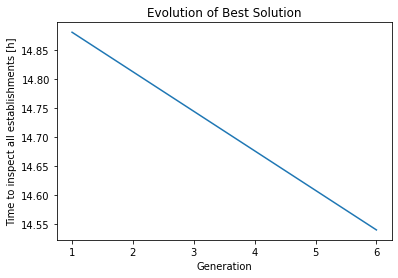

+-------------+---------------------------------------------------------------+
|   Vehicle   |                              IDs                              |
+-------------+---------------------------------------------------------------+
|  Vehicle 1  |       [  0 730 577 166 611 440 199  66 557 753  28   0]       |
|  Vehicle 2  |       [  0 693 406 446 229  20 263 520 970 874 244   0]       |
|  Vehicle 3  |       [  0 355 840 261 600 526 352 199 627  86 572   0]       |
|  Vehicle 4  |       [  0 711 236 628 988 779 739 809 768 772 148   0]       |
|  Vehicle 5  |       [  0 875 543  27  56 658  87 367 785 869 700   0]       |
|  Vehicle 6  |       [  0 634 357 798 521 613 950 942 808 471 752   0]       |
|  Vehicle 7  |       [  0  72 109 924 969 292 799  33 867 890 790   0]       |
|  Vehicle 8  |       [  0 300 670 522 392 957 388 732 255 476  64   0]       |
|  Vehicle 9  |       [  0 513  93 740 523 913 701 527 947  19  44   0]       |
|  Vehicle 10 |       [  0 620 372 958 2

In [ ]:
result_1000_establishments = genetic_algorithm(50,20,1000,0.7,700,0.4,20,0.5,0.05,problem)

## Simulated Annealing

In [31]:
#Simulated annealing

def get_neighbour_solution(tour, problem,n):
    zeros_indices = np.where(tour == 0)[0]  # get the indices of the zeros in the tour
    zeros_positions = zeros_indices.argsort()  # get the positions of the zeros in the tour
    tour_without_zeros = tour[tour != 0]  # remove the zeros from the tour
    best_tour = tour
    best_time = problem.evaluate_solution(tour)
    t = len(tour_without_zeros)
    for i in range(1, t-1, int(n/20)):
        for j in range(i+1, t,int(n/20)):
            new_tour_without_zeros = np.concatenate((tour_without_zeros[:i], tour_without_zeros[i:j+1][::-1], tour_without_zeros[j+1:]))
            count=0
            count_2=0
            new_tour=np.zeros(len(tour))
            for k in range(len(tour)):
                if k != zeros_indices[count]:
                    new_tour[k]=new_tour_without_zeros[count_2]
                    count_2+=1
                else:
                    count+=1
            new_time = problem.evaluate_solution(new_tour.astype(int))
            if new_time > best_time:
                best_tour = new_tour
                best_time = new_time
    return best_tour.astype(int)

def get_sa_solution(num_iterations, problem,n, log=False):
    start_time = time.time()
    distances,inspection_times,schedule, latitudes, longitudes=import_excel()
    problem=problem(distances, inspection_times, schedule, n)
    iteration = 0;
    iterations_exec=0 #number of iterations executed
    temperature = 1000;
    solution = generate_random_solution(n) # Best solution after 'num_iterations' iterations without improvement
    score = problem.evaluate_solution(solution)

    best_solution = copy.deepcopy(solution)
    best_score = score
    best_scores=[]
    print(f"Initial Solution:  {best_solution},  time to inspect all establishments: {-int(best_score)} h {int((best_score % 1)*60)} min")
    initial_solution = best_solution
    while iteration < num_iterations:
        temperature = temperature * 0.999  # Test with different cooling schedules
        iteration += 1
        iterations_exec+=1
        neighbour_solution = get_neighbour_solution(best_solution,problem,n)  #Test with Neighbour 1, 2 and 3
        neighbour_score = problem.evaluate_solution(neighbour_solution)
        delta = neighbour_score - score

        if delta > 0 or np.exp(-delta/temperature) > random.random():
            solution = neighbour_solution
            score = neighbour_score
            if score > best_score:
                iteration = 0
                best_solution = copy.deepcopy(solution)
                best_score = score
                best_scores.append(-score)
                if log:
                    print(f"Solution:       {best_solution}, score: {best_score},  Temp: {temperature}")
    end_time = time.time()
    time_running= round(end_time - start_time,3)
    print(f"Final Solution: {best_solution}, time to inspect all establishments: {-int(best_score)} h {int((best_score % 1)*60)} min")
    print(f"  Number of vehicles utilized: {int(n/10)}")
    print(f"  Number of inspected economic operators: {n}")
    # plot evolution data
    plt.plot(list(range(1, len(best_scores)+1)), best_scores)
    plt.xlabel('best solution')
    plt.ylabel('Time to inspect all establishments [h]')
    plt.title('Evolution of Best Solution')
    plt.show()

    #ID list
    vehicles = np.reshape(best_solution, (int(n/10), 12))
    # initialize table with headers
    table= PrettyTable()
    table.field_names = ['Vehicle', 'IDs']
    # iterate over each route in the list of routes
    for i, route in enumerate(vehicles):
      # add row to the table for the current route
      table.add_row([f'Vehicle {i+1}', route])
    # print the table
    print(table)
    print(f"total time spent running the algorithm: {time_running} s")
    print(f"number of iterations to reach the optimal solution: {iterations_exec-num_iterations}")
    print(f"total number of iterations executed: {iterations_exec}")
    return best_solution, initial_solution

### 20 establishments

In [32]:
SA_20_establishments=get_sa_solution(300,problem,20)
best = SA_20_establishments[0]
initial = SA_20_establishments[1]

Initial Solution:  [ 0  4 10  8  7  2 18 17  6 19 20  0  0 16  5 11 13 14 12 15  1  3  9  0],  time to inspect all establishments: 30 h 30 min
Final Solution: [ 0  4  1  3 13 20  7  8 17  2 14  0  0 12  6  5 16 19  9 15 10 11 18  0], time to inspect all establishments: 15 h 17 min
  Number of vehicles utilized: 2
  Number of inspected economic operators: 20
+-----------+---------------------------------------+
|  Vehicle  |                  IDs                  |
+-----------+---------------------------------------+
| Vehicle 1 | [ 0  4  1  3 13 20  7  8 17  2 14  0] |
| Vehicle 2 | [ 0 12  6  5 16 19  9 15 10 11 18  0] |
+-----------+---------------------------------------+
total time spent running the algorithm: 16.876 s
number of iterations to reach the optimal solution: 20
total number of iterations executed: 320


#### Map visualization

In [33]:
import folium

# generate initial and final solutions

# The establishment locations
distances, inspection_times, schedule, latitudes, longitudes = import_excel()
location_list = [(lat, long) for lat, long in zip(latitudes, longitudes)]
# Convert the location list to a numpy array
locations = np.array(location_list)

print("INITIAL SOLUTION:\n")
# The solution order
solution_order = initial

# Create the map object
m = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=13)

# Plot the solution path
for i in range(len(solution_order) - 1):
    start = solution_order[i] - 1
    end = solution_order[i+1] - 1
    folium.PolyLine([[locations[start, 0], locations[start, 1]], [locations[end, 0], locations[end, 1]]], color='green').add_to(m)

# Plot the depot
folium.Marker(location=[latitudes[0], longitudes[0]], icon=folium.Icon(color='red')).add_to(m)

# Plot the establishments in the solution path
establishments_in_path = [i for i in solution_order[1:] if i != 1]
for i in establishments_in_path:
    folium.Marker(location=[latitudes[i-1], longitudes[i-1]], icon=folium.Icon(color='blue')).add_to(m)

# Show the map
m

INITIAL SOLUTION:



In [34]:

print("FINAL SOLUTION:\n")
# The solution order
solution_order = best

# Create the map object
m = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=13)

# Plot the solution path
for i in range(len(solution_order) - 1):
    start = solution_order[i] - 1
    end = solution_order[i+1] - 1
    folium.PolyLine([[locations[start, 0], locations[start, 1]], [locations[end, 0], locations[end, 1]]], color='green').add_to(m)

# Plot the depot
folium.Marker(location=[latitudes[0], longitudes[0]], icon=folium.Icon(color='red')).add_to(m)

# Plot the establishments in the solution path
establishments_in_path = [i for i in solution_order[1:] if i != 1]
for i in establishments_in_path:
    folium.Marker(location=[latitudes[i-1], longitudes[i-1]], icon=folium.Icon(color='blue')).add_to(m)

# Show the map
m


FINAL SOLUTION:



### 100 establishments

In [35]:
SA_100_establishments=get_sa_solution(50,problem,100)

Initial Solution:  [  0  55   6  13  48  32  95  56  25  71  27   0   0  65  18  68  21  37
  62  63  77   1  29   0   0  97  86  44   5  60  12  72  35   2  16   0
   0  28  11  39  53  99  87  67  66  10  54   0   0  83  76  45  24  73
  22  17  61  64  47   0   0  33  30  85  34   4  23  38  98  20  93   0
   0  15  49  40  70  59  36  90   9  41  14   0   0   7  50  52  78  19
  91  51   8  31  96   0   0  84  74  94   3  80  75  57  58 100  69   0
   0  92  43  89  26  79  81  88  82  42  46   0],  time to inspect all establishments: 18 h 55 min
Final Solution: [  0  55  89  43  92  69 100  58  57  75  80   0   0   3  94  74  84  96
  31   8  51  91  19   0   0  78  52  50   7  14  41   9  90  36  59   0
   0  70  40  49  15  93  20  98  38  23   4   0   0  34  85  30  33  47
  64  61  17  22  73   0   0  24  45  76  83  54  10  66  67  87  99   0
   0  53  39  11  28  16   2  35  72  12  60   0   0   5  44  86  97  29
   1  77  63  62  37   0   0  21  68  18  65  27  71  25  56  

### 500 establishments

In [36]:
SA_500_establishments=get_sa_solution(50,problem,500)

Initial Solution:  [  0 378 408 179  25 357 324 135 225 149 127   0   0  19 363  84  34 263
 191  67  38 254 148   0   0 159 183 307 142 489 116  99 229  14 418   0
   0 355 391  52 270  69 476  21 237  72 493   0   0  30   1  92 495 246
  37 224 446 251 276   0   0  27 449  12 118 271 232  23 372 210 496   0
   0 150 125 371 381 130  90 189 174 366 467   0   0 384 258 411  49  26
  43 204 445 248 115   0   0 436  83 264  63 299 464 281 290 288 162   0
   0 138 114 341 398 468 163  76 220 209 277   0   0 383 182 261 119 242
 285 259 327 318  28   0   0 153 296 345 471 177 485 473  16 487 105   0
   0 430 373 360 382 353  18 422 200 106 139   0   0 393 396 315  62 124
  71  87 350  56 488   0   0 216 469 102 301 227 377  44 332 157 348   0
   0 388 380  82 158 387 402 211 292 169 129   0   0 415 389  50 121 447
 112 195 414 291  86   0   0 370 184 207 272 274 499 435 344 452  29   0
   0 440  35 137  41  64 178 186  11 128 326   0   0  55 241 257 335 352
  97 498 347 354 451   0   0 429

### 1000 establishments

Initial Solution:  [  0 685 187 ...  13 626   0],  time to inspect all establishments: 31 h 30 min
Final Solution: [  0 685 187 ...  13 626   0], time to inspect all establishments: 31 h 30 min
  Number of vehicles utilized: 100
  Number of inspected economic operators: 1000


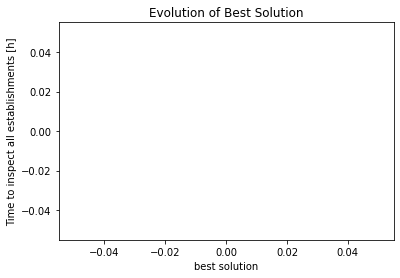

+-------------+---------------------------------------------------------------+
|   Vehicle   |                              IDs                              |
+-------------+---------------------------------------------------------------+
|  Vehicle 1  |       [  0 685 187 272 967 171 318 151  19 775 689   0]       |
|  Vehicle 2  |       [  0 444 578 701 459 809 570 652 608 437 475   0]       |
|  Vehicle 3  |       [  0 867 589  91 812 306 933 528 631 889 374   0]       |
|  Vehicle 4  |       [  0 944 927 482 864 291 777 954 382 794 804   0]       |
|  Vehicle 5  |       [  0 711 288 860  31 105 810 133 551 834 692   0]       |
|  Vehicle 6  |       [  0  70 134 331 987 780 953 267 781 979 230   0]       |
|  Vehicle 7  |       [  0 564 213 144 754  32  56 575 731 830 675   0]       |
|  Vehicle 8  |       [  0 264 296 818   1  75 483 295 527 162 536   0]       |
|  Vehicle 9  |       [  0 825 802 591 985 159 201 338 614 984  40   0]       |
|  Vehicle 10 |       [  0 593  22 205 5

In [ ]:
SA_1000_establishments=get_sa_solution(50,problem,1000)

## Hill Climbing

In [15]:
def generate_random_neighbor(solution, problem):
    num_swaps=(problem.num_vehicles)  #makes the number of swaps in mutation be adjusted to the data size
    non_zero_indices = [i for i in range(len(solution)) if solution[i] != 0]
    indices = random.sample(non_zero_indices, num_swaps)
    for i in range(0, len(indices), 2):
        index_1 = indices[i]
        index_2 = indices[i+1]
        solution[index_1], solution[index_2] = solution[index_2], solution[index_1]
    return solution

def hill_climbing(num_iterations, num_establishments,problem,  log=False):
  start_time = time.time()
  distances,inspection_times,schedule, latitudes, longitudes=import_excel()
  problem=problem(distances, inspection_times, schedule, num_establishments)

  current_solution = generate_random_solution(num_establishments) # In the Hill Climbing algorithm, typically one initial solution is needed
  current_score = problem.evaluate_solution(current_solution)
  if log:
    print(f"Initial solution: {current_solution}, time to inspect all establishments: {-int(current_score)} h {int((current_score % 1)*60)} min")
  else:
    print(f"Initial solution. Time to inspect all establishments: {-int(current_score)} h {int((current_score % 1)*60)} min")

  best_solution_iteration = 0 # Iteration on which the best solution was found
  best_score = current_score
  best_solution = current_solution.copy()
  best_scores = []

  if log:
    print(f"Iteration 0: best score={-int(best_score)}, best solution={best_solution}")

  for i in range(1, num_iterations + 1):
    # Generate neighboring solution
    neighbor_solution = generate_random_neighbor(current_solution,problem)
    neighbor_score = problem.evaluate_solution(neighbor_solution)
    # Check if neighboring solution is better
    if neighbor_score > current_score:
        current_solution = neighbor_solution
        current_score = neighbor_score

        if neighbor_score > best_score:
            best_solution = neighbor_solution.copy()
            best_solution_iteration = i
            best_score = neighbor_score
            if log:
                    print(f"Iteration {i}: best score={-int(best_score)}, best solution={best_solution}")
        elif log:
            print(f"Iteration {i}: score={neighbor_score}, solution={neighbor_solution}")
    best_scores.append(best_score)
    if log:
        print(f"Best score ({-int(best_score)}) found on iteration {best_solution_iteration}")


  if log:
    print(f"Final solution: {best_solution} was found on iteration {best_solution_iteration}, time to inspect all establishments: {-int(best_score)} h {int((best_score % 1)*60)} min")
  else:
    print(f"Final solution was found on iteration {best_solution_iteration}, time to inspect all establishments: {-int(best_score)} h {int((best_score % 1)*60)} min")

  end_time = time.time()
  time_running= round(end_time - start_time,3)

  # plot evolution data
  best_scores_positive = [-score for score in best_scores]
  plt.plot(list(range(1, len(best_scores_positive)+1)), best_scores_positive)
  plt.xlabel('Iterations')
  plt.ylabel('Time to inspect all establishments')
  plt.title('Evolution of Best Solution')
  plt.show()

  print(f"total time spent running the algorithm: {time_running} s")
  return current_solution

Initial solution. Time to inspect all establishments: 20 h 28 min
Final solution was found on iteration 43, time to inspect all establishments: 16 h 4 min


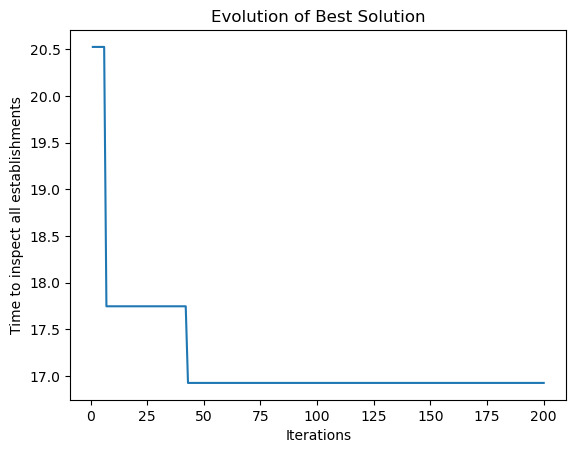

total time spent running the algorithm: 3.13 s


In [16]:
hc_20_establishments=hill_climbing(200,20,problem)

Initial solution. Time to inspect all establishments: 27 h 6 min
Final solution was found on iteration 8, time to inspect all establishments: 15 h 35 min


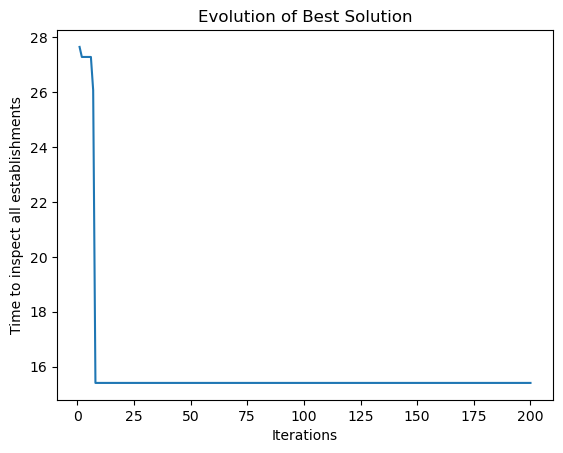

total time spent running the algorithm: 4.773 s


In [17]:
hc_100_establishments=hill_climbing(200,1000,problem)

# Resource allocation minimization

## Evaluation function

In [2]:
#Evaluation function
INSPECTION_TIME = 5/60  # it takes 5 min (300 sec) to inspect each establishment
class ResourceAllocationMinimization:
    def __init__(self, distances, inspection_times, schedule, n):
        self.distances = distances
        self.inspection_time = inspection_times / 3600
        self.schedule = schedule
        self.num_establishments = n

    # solution is a list of establishment indices, e.g. [4 1 5 3 2]
    def evaluate_solution(self, solution):
        route = list(solution)
        total_travel_time = self.distances[0][route[0]] / 3600
        total_inspection_time = 0
        total_waiting_time = 0
        waiting_time = 0
        current_time = 9 + total_travel_time
        current_vehicle = 1
        visited_nodes = []

        for i in range(len(route) - 1):
            waiting_time = 0
            start = route[i]
            end = route[i + 1]
            if current_time - 9 >= 8 or current_time + self.distances[start][end] / 3600 - 9 >= 8:
                current_vehicle += 1
                current_time = 9
                visited_nodes = []
                # the new vehicle starts at 9 am and works until 5 pm
                # it should start from node 0 and go to the next unvisited establishment
                total_travel_time += self.distances[0][route[i + 1]] / 3600
                current_time += self.distances[0][route[i + 1]] / 3600
            total_travel_time += self.distances[start][end] / 3600
            open_hours = self.schedule[start]
            current_time += self.distances[start][end] / 3600
            # check if establishment is open
            if open_hours[int(current_time)] == 1:
                total_inspection_time += INSPECTION_TIME
                current_time += INSPECTION_TIME
            # if not, wait until it opens
            else:
                waiting_time += int(current_time) + 1 - current_time
                next_open_time = int(current_time) + 1
                current_time += waiting_time
                while open_hours[next_open_time] == 0 and current_time - 9 <= 8:
                    waiting_time += 1
                    next_open_time += 1
                    current_time += waiting_time
                total_inspection_time += INSPECTION_TIME
                total_waiting_time += waiting_time
                current_time += INSPECTION_TIME
            visited_nodes.append(start)
        total_time = total_travel_time + total_inspection_time + total_waiting_time
        return (-current_vehicle)
        return (-current_vehicle)


def problem2(distances, inspection_time, schedule, n):
    problem = ResourceAllocationMinimization(distances, inspection_time, schedule, n)
    return problem

## Auxiliary functions

In [3]:
# auxiliary functions
def pool_select_parents(population_size, pool, Pcross):  #selects parents from the pool with Pcross percentage of the population to be chose as parents
    num_parents = int(population_size * Pcross)
    if num_parents % 2 == 1:
      num_parents -= 1
    parent_indices = []
    selected_parents = set()
    while len(selected_parents) < num_parents:
        x = np.random.randint(len(pool))
        individual = tuple(pool[x])
        if individual not in selected_parents:
            selected_parents.add(individual)
            parent_indices.append(x)
    parents = [pool[i] for i in parent_indices]
    return parents

def roulette_select(population,scores): #roulette selection
    score_sum = np.sum(scores)
    selection_probabilities = scores / score_sum
    return population[np.random.choice(len(population), p=selection_probabilities)]

def roulette_select_pool(population, pool_size, scores): #roulette selection to a pool
    pool = []
    for i in range(pool_size):
        selected_solution = roulette_select(population, scores)
        pool.append(selected_solution)
    return pool

def tournament_select_pool(population, pool_size, tournament_size, scores): #tournament selection to a pool
    pool = []
    for i in range(pool_size):
        selected_solution = tournament_select(population, tournament_size, scores)
        pool.append(selected_solution)
    return pool

def roulette_and_tournament_select_pool(population, pool_size, tourn_p, tournament_size, scores): #combines roulette and tournament selection to a pool
    roulette_size = int(pool_size * (1 - tourn_p))
    tournament_pool_size = int(pool_size * tourn_p)
    pool = roulette_select_pool(population, roulette_size, scores)
    tournament_pool = tournament_select_pool(population, tournament_pool_size, tournament_size, scores)
    pool.extend(tournament_pool)
    return pool

def tournament_select(population, tournament_size, scores): #tournament selection
    population_copy = copy.deepcopy(population)
    best_solution = population_copy[0]
    best_score = scores[0]
    for i in range(tournament_size):
        index = np.random.randint(0, len(population_copy))
        score = scores[index]
        if score > best_score:
            best_score = score
            best_solution = population_copy[index]
        del population_copy[index]
    return best_solution

def offspring(parents): #generates offspring through crossover
    num_parents = (len(parents))
    offspring = []
    for i in range(0, num_parents, 2):
        solution_1 = parents[i]
        solution_2 = parents[i+1]
        child_1, child_2 = ordered_random_two_point_crossover(solution_1, solution_2)
        # Convert strings to numpy arrays
        child_1 = np.array([int(digit) for digit in child_1[1:-1]])
        child_2 = np.array([int(digit) for digit in child_2[1:-1]])
        child_1= np.concatenate(([0], child_1, [0]))
        child_2= np.concatenate(([0], child_2, [0]))
        offspring.append(child_1)
        offspring.append(child_2)
    return offspring

def ordered_random_two_point_crossover(solution_1, solution_2):
    #Performs ordered random two-point crossover between two solutions
    length = len(solution_1)
    crossover_points = sorted([random.randint(0, length), random.randint(0, length)])
    zeros = [i for i in range(length) if solution_1[i] == 0 or solution_2[i] == 0]
    child_1 = [0] * length
    child_2 = [0] * length

    # First child
    for i in range(crossover_points[0], crossover_points[1]):
        child_1[i] = solution_1[i]
    j = 0
    for i in range(length):
        if solution_2[i] not in child_1 and solution_2[i] != 0:
            if i not in zeros:
                child_1[i] = solution_2[i]
                j += 1
        else:
            child_1[i] = solution_1[i]

    # Second child
    for i in range(crossover_points[0], crossover_points[1]):
        child_2[i] = solution_2[i]
    j = 0
    for i in range(length):
        if solution_1[i] not in child_2 and solution_1[i] != 0:
            if i not in zeros:
                child_2[i] = solution_1[i]
                j += 1
        else:
            child_2[i] = solution_2[i]

    return child_1, child_2


def replace_worst_individuals(population, offspring,scores):
    # sort population by fitness in ascending order

    sorted_indices = np.argsort(scores)
    sorted_population = [population[i] for i in sorted_indices]

    # replace the worst individuals in the sorted population with offspring
    num_offspring = len(offspring)
    for i in range(num_offspring):
        sorted_population[-(i+1)] = offspring[i]

    # return the updated population
    return sorted_population


def get_greatest_fit(population,scores):
    best_solution = population[0]
    best_score = scores[0]
    for i in range(1, len(population)):
        score = scores[i]
        if score > best_score:
            best_score = score
            best_solution = population[i]
    return best_solution, best_score

def generate_random_solution2(n):
    # Generate a random permutation of the numbers from 1 to k
    values = np.random.permutation(np.arange(1, n + 1))
    return [int(x) for x in values]

# initial solution
def generate_population2(population_size,n):
    solutions = []
    for i in range(population_size):
        solutions.append(generate_random_solution2(n))
    return solutions



def invert_mutation(solution):
    """
    Randomly select two cities in the genotype and reverse the order of the cities between them.
    """
    # Select two distinct cities at random
    i, j = sorted(random.sample(range(1, len(solution)-1), 2))
    # Reverse the order of cities between i and j
    new_solution = solution[:i] + solution[j:i-1:-1] + solution[j+1:]
    return new_solution

def swap_mutation(solution):
    # Select two random cities to swap
    idx1, idx2 = random.sample(range(1, len(solution) - 1), 2)
    # Swap their positions in the genotype
    solution[idx1], solution[idx2] = solution[idx2], solution[idx1]
    return solution

def mutate_population2(population, Pmutate,p_nei, problem):
    mutated_population = []
    for individual in population:
        if np.random.rand() < Pmutate:
            if np.random.rand() <p_nei:
              mutated_individual = swap_mutation(individual)
            else:
              mutated_individual = swap_mutation(individual)
        else:
            mutated_individual = individual
        mutated_population.append(mutated_individual)
    return mutated_population


def evolve_population2(population,population_size, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, scores, problem):
    parents = pool_select_parents(population_size, roulette_and_tournament_select_pool(population,pool_size, tourn_p, tournament_size, scores), Pcross)
    offsp = offspring(parents)
    offsp=mutate_population2(offsp, Pmutate,p_nei,problem)
    population = replace_worst_individuals(population, offsp,scores)
    return population

def evolve_population(population,population_size, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, scores, problem,n):
    parents = pool_select_parents(population_size, roulette_and_tournament_select_pool(population,pool_size, tourn_p, tournament_size, scores), Pcross)
    offsp = offspring(parents)
    offsp=mutate_population(offsp, Pmutate,p_nei,problem,n)
    population=replace_worst_individuals(population, offsp,scores)
    return population

## Genetic Algorithm

In [4]:
#Resource allocation minimization - Genetic Algorithm

def genetic_algorithm2(num_iterations, num_establishments, population_size, Pcross, pool_size, tourn_p, tournament_size, Pmutate, p_nei,  log=False):
  start_time = time.time()
  distances,inspection_times,schedule, latitudes, longitudes=import_excel()
  problem=problem2(distances, INSPECTION_TIME, schedule, num_establishments)
  population = generate_population2(population_size,num_establishments)

  initial_solution = population[0] # Initial solution
  best_solution = initial_solution.copy()
  best_score = problem.evaluate_solution(population[0])
  best_solution_generation = 0 # Generation on which the best solution was found
  generation_no = 0

  print(f"Initial solution: {best_solution}, number of vehicles required to inspect all establishments: {-int(best_score)}")
  best_scores = []
  best_solutions = []
  generations=[]
  while(num_iterations > 0):
    generation_no += 1
    scores = []
    for individual in population:
      scores.append(problem.evaluate_solution(individual))
    scores = np.array(scores)

    population = evolve_population2(population,population_size, Pcross, pool_size, tourn_p, tournament_size, Pmutate,p_nei, scores, problem)
    # Checking the greatest fit among the current population
    greatest_fit, greatest_fit_score = get_greatest_fit(population,scores)
    if greatest_fit_score > best_score:
            best_solution = greatest_fit
            best_score = greatest_fit_score
            best_solution_generation = generation_no
            best_scores.append(-best_score)
            best_solutions.append(best_solution)
            generations.append(generation_no)
            if log:
                print(f"\nGeneration: {generation_no }")
                print(f"Solution: {best_solution}, score: {best_score}")
    else:
            num_iterations -= 1
            generations.append(generation_no)
            best_scores.append(-best_score)
    if log:
        print(f"best solution {generation_no}th generation - {best_score}")  # uncomment to check every geenration difference
  end_time = time.time()
  time_running= round(end_time - start_time,3)
  print(f"  Final solution: best_solution, vehicles required to inspect all establishments: {-best_score} ")
  print(f"  Found on generation {best_solution_generation}")
  # plot evolution data
  plt.plot(list(range(1, len(best_scores)+1)), best_scores)
  plt.plot(generations, best_scores)
  plt.xlabel('Generation')
  plt.ylabel('number of vehicles required')
  plt.title('Evolution of Best Solution')
  plt.show()

  print(f"total time spent running the algorithm: {time_running} s")
  return best_solution, initial_solution, best_scores

Initial solution: [482, 714, 567, 480, 431, 667, 897, 406, 404, 972, 578, 615, 168, 508, 44, 724, 929, 227, 471, 762, 239, 368, 184, 228, 805, 248, 125, 935, 715, 719, 308, 963, 193, 39, 393, 673, 396, 141, 912, 971, 252, 264, 587, 362, 626, 116, 603, 905, 611, 117, 671, 753, 989, 236, 42, 683, 7, 637, 713, 411, 274, 531, 532, 209, 365, 631, 747, 21, 951, 387, 638, 384, 135, 652, 367, 952, 953, 880, 878, 433, 533, 688, 866, 16, 395, 754, 690, 806, 133, 623, 445, 162, 405, 269, 366, 153, 270, 356, 74, 374, 709, 489, 546, 889, 958, 721, 249, 319, 756, 176, 772, 704, 722, 218, 624, 691, 968, 763, 301, 588, 138, 940, 19, 460, 146, 814, 491, 479, 696, 86, 358, 923, 575, 802, 582, 293, 15, 858, 888, 773, 22, 555, 998, 875, 240, 534, 472, 837, 584, 616, 803, 265, 105, 993, 40, 566, 585, 775, 571, 992, 82, 197, 662, 602, 538, 976, 292, 994, 347, 305, 286, 826, 913, 143, 436, 565, 328, 329, 581, 886, 191, 279, 786, 617, 485, 421, 80, 179, 484, 677, 285, 857, 718, 892, 619, 620, 794, 627, 636, 6

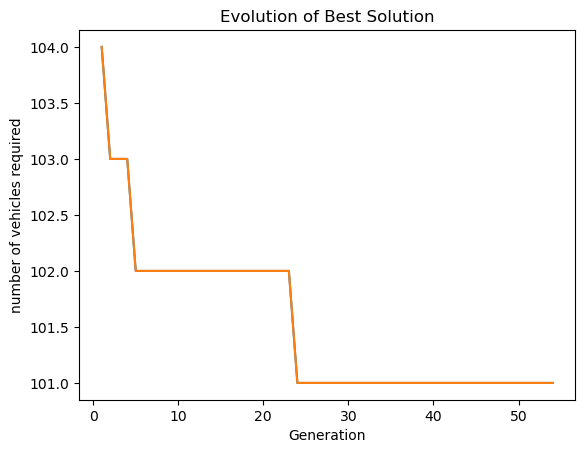

total time spent running the algorithm: 29.131 s


In [5]:
resourceAllocationResult = genetic_algorithm2(50, 1000, 25, 0.7,700,0.4,20,0.7,0.3)

## Simulated Annealing

In [6]:
def swap_establishments(solution):
    # Choose two random establishments to swap
    i, j = random.sample(range(len(solution)), 2)
    # Swap the establishments in the solution
    new_solution = solution.copy()
    new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
    return new_solution

def simulated_annealing(num_iterations, num_establishments, log=False):
    start_time = time.time()
    distances, inspection_times, schedule, latitudes, longitudes = import_excel()
    problem = problem2(distances, inspection_times, schedule, num_establishments)
    iteration = 0
    iterations_exec = 0  # number of iterations executed
    best_iteration = 0
    temperature = 1000
    cooling_rate = 0.95
    solution = generate_random_solution2(num_establishments)
    score = -problem.evaluate_solution(solution)  # Negate the score
    best_solution = copy.deepcopy(solution)
    best_score = score
    best_scores = []
    print(f"Initial Solution: best_solution, vehicles to inspect all establishments: {best_score}")
    initial_solution = best_solution
    while iteration < num_iterations:
        new_solution = swap_establishments(solution)
        new_score = -problem.evaluate_solution(new_solution)  # Negate the score

        if new_score < score:
            # Accept the new solution if it is better
            solution = new_solution
            score = new_score
        else:
            # Accept the new solution with probability based on temperature
            delta_score = new_score - score
            acceptance_probability = math.exp(-delta_score / temperature)
            if random.random() < acceptance_probability:
                solution = new_solution
                score = new_score

        # Update the best solution if necessary
        if score < best_score:
            best_solution = copy.deepcopy(solution)
            best_score = score
            best_iteration = iteration

        # Reduce the temperature by the cooling rate
        temperature *= cooling_rate
        iteration += 1
        iterations_exec += 1

        # Log the best score and solution
        best_scores.append(-best_score)
        if log and iterations_exec % 100 == 0:
            print(f"Iteration {iterations_exec}, Best solution: best_solution, vehicles to inspect all establishments: {-best_score}")

    end_time = time.time()
    time_running= round(end_time - start_time,3)

    print(f"Best solution: best_solution, vehicles to inspect all establishments: {best_score}, Time elapsed: {time_running:.2f} seconds")
    print(f"Best solution found at iteration {best_iteration}")

    # plot evolution data
    best_scores_positive = [-score for score in best_scores]
    plt.plot(list(range(1, len(best_scores_positive)+1)), best_scores_positive)
    plt.xlabel('Iterations')
    plt.ylabel('Number of vehicles to inspect all establishments')
    plt.title('Evolution of Best Solution')
    plt.show()

    print(f"total time spent running the algorithm: {time_running} s")

    return best_solution, initial_solution, best_scores_positive


Initial Solution: best_solution, vehicles to inspect all establishments: 105
Best solution: best_solution, vehicles to inspect all establishments: 85, Time elapsed: 6.44 seconds
Best solution found at iteration 724


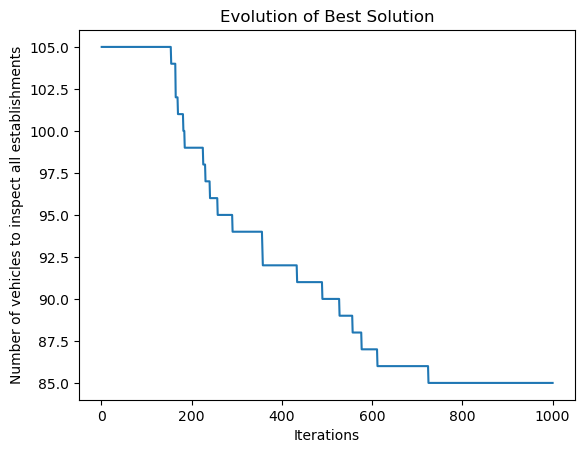

total time spent running the algorithm: 6.444 s


In [7]:
SA_resourceAllocation=simulated_annealing(1000,1000)

Plot a visiting graph

In [8]:
import folium

# get initial solution
initial_solution = SA_resourceAllocation[1]

# Import locations
distances, inspection_times, schedule, latitudes, longitudes = import_excel()
location_list = [(lat, long) for lat, long in zip(latitudes, longitudes)]
# Convert the location list to a numpy array
locations = np.array(location_list)

print("INITIAL SOLUTION:\n")
solution_order = initial_solution

# Create the map object
m = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=13)

# Plot the solution path
for i in range(len(solution_order) - 1):
    start = solution_order[i] - 1
    end = solution_order[i+1] - 1
    folium.PolyLine([[locations[start, 0], locations[start, 1]], [locations[end, 0], locations[end, 1]]], color='green').add_to(m)

# Plot the depot
folium.Marker(location=[latitudes[0], longitudes[0]], icon=folium.Icon(color='red')).add_to(m)

# Plot the establishments in the solution path
establishments_in_path = [i for i in solution_order[1:] if i != 1]
for i in establishments_in_path:
    folium.Marker(location=[latitudes[i-1], longitudes[i-1]], icon=folium.Icon(color='blue')).add_to(m)

# Show the map
m

INITIAL SOLUTION:



Plot the visiting graph on a real map using latitudes and longitudes of the establishments

In [9]:
print("FINAL SOLUTION:\n")

# get final solution
best_solution = SA_resourceAllocation[0]

# The solution order
solution_order = best_solution

# Create the map object
m = folium.Map(location=[latitudes[0], longitudes[0]], zoom_start=13)

# Plot the solution path
for i in range(len(solution_order) - 1):
    start = solution_order[i] - 1
    end = solution_order[i+1] - 1
    folium.PolyLine([[locations[start, 0], locations[start, 1]], [locations[end, 0], locations[end, 1]]], color='green').add_to(m)

# Plot the depot
folium.Marker(location=[latitudes[0], longitudes[0]], icon=folium.Icon(color='red')).add_to(m)

# Plot the establishments in the solution path
establishments_in_path = [i for i in solution_order[1:] if i != 1]
for i in establishments_in_path:
    folium.Marker(location=[latitudes[i-1], longitudes[i-1]], icon=folium.Icon(color='blue')).add_to(m)

# Show the map
m


FINAL SOLUTION:



## Hill Climbing

In [10]:
def generate_neighbor(solution):
    n = len(solution)
    i, j = np.random.randint(n, size=2)
    neighbor = solution.copy()
    neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
    return neighbor

def hill_climbing(num_iterations, num_establishments,  log=False):
  start_time = time.time()
  distances,inspection_times,schedule, latitudes, longitudes=import_excel()
  problem=problem2(distances, INSPECTION_TIME, schedule, num_establishments)

  initial_solution = generate_population2(1,num_establishments)[0] # In the Hill Climbing algorithm, typically one initial solution is needed
  current_solution = initial_solution.copy()
  current_score = problem.evaluate_solution(current_solution)
  if log:
    print(f"Initial solution: {current_solution}, number of vehicles required to inspect all establishments: {-int(current_score)}")
  else:
    print(f"Initial solution. Number of vehicles required to inspect all establishments: {-int(current_score)}")

  best_solution_iteration = 0 # Iteration on which the best solution was found
  best_score = current_score
  best_solution = current_solution.copy()
  best_scores = []

  if log:
    print(f"Iteration 0: best score={-int(best_score)}, best solution={best_solution}")

  for i in range(1, num_iterations + 1):
    # Generate neighboring solution
    neighbor_solution = generate_neighbor(current_solution)
    neighbor_score = problem.evaluate_solution(neighbor_solution)
    # Check if neighboring solution is better
    if neighbor_score > current_score:
        current_solution = neighbor_solution
        current_score = neighbor_score

        if neighbor_score > best_score:
            best_solution = neighbor_solution.copy()
            best_solution_iteration = i
            best_score = neighbor_score
            if log:
                    print(f"Iteration {i}: best score={-int(best_score)}, best solution={best_solution}")
        elif log:
            print(f"Iteration {i}: score={neighbor_score}, solution={neighbor_solution}")
    best_scores.append(best_score)
    if log:
        print(f"Best score ({-int(best_score)}) found on iteration {best_solution_iteration}")


  if log:
    print(f"Final solution: {best_solution} was found on iteration {best_solution_iteration}, number of vehicles required to inspect all establishments: {-int(best_score)}")
  else:
    print(f"Final solution was found on iteration {best_solution_iteration}, number of vehicles required to inspect all establishments: {-int(best_score)}")

  end_time = time.time()
  time_running= round(end_time - start_time,3)

  # plot evolution data
  best_scores_positive = [-score for score in best_scores]
  plt.plot(list(range(1, len(best_scores_positive)+1)), best_scores_positive)
  plt.xlabel('Iterations')
  plt.ylabel('Number of vehicles to inspect all establishments')
  plt.title('Evolution of Best Solution')
  plt.show()

  print(f"total time spent running the algorithm: {time_running} s")
  return current_solution, initial_solution, best_scores_positive

Initial solution. Number of vehicles required to inspect all establishments: 53
Final solution was found on iteration 525, number of vehicles required to inspect all establishments: 42


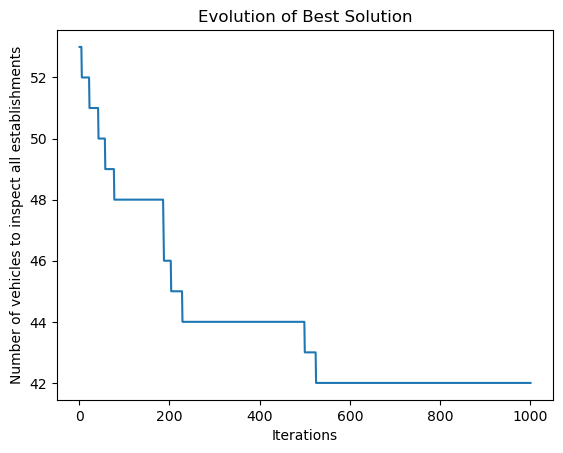

total time spent running the algorithm: 4.178 s


In [11]:
resourceAllocationResult = hill_climbing(1000, 500)

## Tabu Search

In [12]:
def tabu_search(num_iterations, num_establishments, tabu_list_size=5, tabu_tenure=3, log=False):
    start_time = time.time()
    distances, inspection_times, schedule, latitudes, longitudes = import_excel()
    problem = problem2(distances, INSPECTION_TIME, schedule, num_establishments)

    initial_solution = generate_population2(1, num_establishments)[0] # In the Hill Climbing algorithm, typically one initial solution is needed
    current_solution = initial_solution.copy()
    current_score = problem.evaluate_solution(current_solution)
    print(f"Parameters: num_iterations: {num_iterations}, num_establishments: {num_establishments}, tabu_list_size: {tabu_list_size}, tabu_tenure: {tabu_tenure}")
    print(f"Initial solution: {current_solution}, number of vehicles required to inspect all establishments: {-int(current_score)}")

    best_solution_iteration = 0 # Iteration on which the best solution was found
    best_score = current_score
    best_solution = current_solution.copy()
    if log:
        print(f"Iteration 0: best score={-int(best_score)}, best solution={best_solution}")

    tabu_list = deque(maxlen=tabu_list_size)

    best_scores = []  # Keep track of the best score at each iteration
    best_scores.append(best_score)

    tabu_tenure_min = 1
    tabu_tenure_max = 5
    tabu_tenure_step = 1

    for it in range(num_iterations):
        # Generate all possible moves
        moves = []
        for i in range(num_establishments):
            for j in range(i + 1, num_establishments):
                move = (i, j)
                moves.append(move)

        # Evaluate each move and select the best one
        best_move = None
        best_move_score = float('-inf')
        for move in moves:
            # Skip move if it's in the tabu list
            if move in tabu_list:
                continue

            # Make the move and evaluate the score
            new_solution = current_solution.copy()
            new_solution[move[0]], new_solution[move[1]] = new_solution[move[1]], new_solution[move[0]]
            new_score = problem.evaluate_solution(new_solution)

            # Update best move
            if new_score > best_move_score:
                best_move = move
                best_move_score = new_score

        # Update current solution with the best move
        current_solution[best_move[0]], current_solution[best_move[1]] = current_solution[best_move[1]], current_solution[best_move[0]]
        current_score = best_move_score

        # Add move to tabu list
        tabu_list.append(best_move)

        # Update best solution if necessary
        if current_score > best_score:
            best_score = current_score
            best_solution = current_solution.copy()
            best_solution_iteration = it

        best_scores.append(best_score)  # Add the best score at this iteration to the list

        # Update tabu tenure based on recent solutions
        if it >= tabu_list_size:
            recent_solutions = [best_scores[i] for i in range(it-tabu_list_size, it)]
            if recent_solutions == sorted(recent_solutions, reverse=True):
                tabu_tenure = min(tabu_tenure+tabu_tenure_step, tabu_tenure_max)
            elif recent_solutions == sorted(recent_solutions):
                tabu_tenure = max(tabu_tenure-tabu_tenure_step, tabu_tenure_min)

        # Remove oldest move from tabu list if necessary
        if len(tabu_list) >= tabu_list_size:
            tabu_list.popleft()

        if log:
            print(f"Iteration {it+1}: best score={-int(best_score)}, best solution={best_solution}, tabu tenure={tabu_tenure}")

    print(f"Final solution: {best_solution} was found on iteration {best_solution_iteration}, number of vehicles required to inspect all establishments: {-int(best_score)}")


    end_time = time.time()
    time_running= round(end_time - start_time,3)


        # plot evolution data
    best_scores_positive = [-score for score in best_scores]
    plt.plot(list(range(1, len(best_scores_positive)+1)), best_scores_positive)
    plt.xlabel('Iterations')
    plt.ylabel('Number of vehicles to inspect all establishments')
    plt.title('Evolution of Best Solution')
    plt.show()


    print(f"total time spent running the algorithm: {time_running} s")
    return best_solution, initial_solution, best_scores_positive

Parameters: num_iterations: 20, num_establishments: 100, tabu_list_size: 50, tabu_tenure: 3
Initial solution: [21, 25, 68, 99, 7, 71, 70, 14, 83, 2, 84, 58, 42, 60, 94, 52, 11, 12, 61, 96, 17, 41, 27, 95, 44, 88, 57, 10, 29, 77, 55, 82, 75, 46, 4, 100, 91, 8, 13, 22, 66, 26, 69, 6, 59, 23, 78, 33, 34, 47, 18, 36, 67, 90, 45, 16, 65, 80, 24, 85, 89, 97, 32, 51, 79, 39, 30, 40, 5, 1, 38, 31, 72, 50, 19, 81, 43, 86, 54, 56, 63, 3, 15, 35, 49, 73, 87, 93, 20, 98, 64, 76, 9, 74, 48, 37, 92, 28, 53, 62], number of vehicles required to inspect all establishments: 13
Final solution: [21, 25, 68, 99, 7, 71, 22, 14, 83, 2, 84, 58, 42, 60, 94, 52, 11, 12, 61, 96, 17, 41, 27, 95, 44, 88, 57, 10, 29, 77, 55, 82, 75, 46, 4, 100, 91, 8, 13, 70, 66, 26, 69, 6, 59, 23, 78, 33, 34, 47, 18, 36, 67, 90, 45, 16, 65, 80, 24, 85, 89, 97, 32, 51, 79, 39, 30, 40, 5, 1, 38, 31, 72, 50, 19, 81, 43, 86, 54, 56, 63, 3, 15, 35, 49, 73, 28, 93, 20, 98, 64, 76, 9, 74, 48, 37, 92, 87, 53, 62] was found on iteration 1,

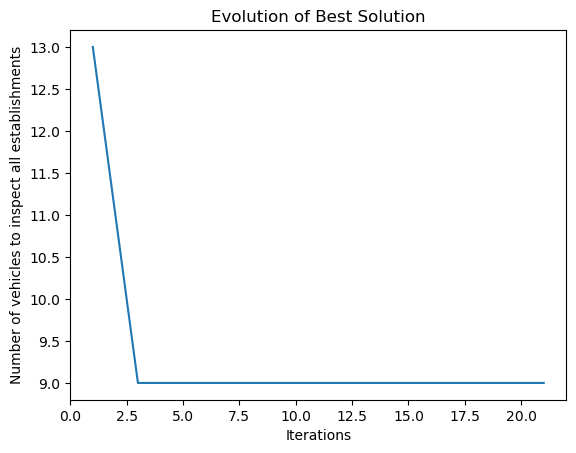

total time spent running the algorithm: 20.168 s


In [13]:
resource_allocation_TS = tabu_search(20, 100,50,3)

# User Interface

Is not supported by colab. Run on Jupyter/Pycharm

Runs only Resource allocation minimization problem

In order to run, all functions in resource allocation minization section should be compiled first.

Suggestion: do not insert many iterations for Tabu search algorithm, as it will take a long time to run...

In [15]:
import tkinter as tk
import time
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from functools import partial

def run_algorithm(algorithm, num_iterations, num_establishments, tabu_list_size, tabu_tenure, popsize):
    try:
        num_iterations = int(num_iterations)
        num_establishments = int(num_establishments)
        if tabu_list_size is not None:
            tabu_list_size = int(tabu_list_size)
        if tabu_tenure is not None:
            tabu_tenure = int(tabu_tenure)
        if popsize is not None:
            popsize = int(popsize)
    except ValueError:
        result_label.config(text=f"Invalid input values. Please enter integers. Type provided is {type(num_iterations)} values: {num_iterations}, {num_establishments}")
        return
    # call the algorithm function with the provided arguments
    # and print the result
    print("Solution is being generated, stand by...")

    if algorithm == 'hill_climbing':
        result_label.config(text="Solution is being generated, stand by...")
        start_time = time.time()
        best_solution, best_scores, best_scores_positive = hill_climbing(num_iterations, num_establishments)
        end_time = time.time()
        total_time = end_time - start_time

    elif algorithm == 'simulated_annealing':
        result_label.config(text="Solution is being generated, stand by...")
        start_time = time.time()
        best_solution, best_scores, best_scores_positive = simulated_annealing(num_iterations, num_establishments)
        end_time = time.time()
        total_time = end_time - start_time

    elif algorithm == 'genetic_algorithm':
        result_label.config(text="Solution is being generated, stand by...")
        start_time = time.time()
        best_solution, best_scores, best_scores_positive = genetic_algorithm2(num_iterations, num_establishments, population_size)
        end_time = time.time()
        total_time = end_time - start_time

    elif algorithm == 'tabu_search':
        result_label.config(text="Solution is being generated, stand by...")
        start_time = time.time()
        if tabu_list_size is not None and tabu_tenure is not None:
            best_solution, best_scores, best_scores_positive = tabu_search(num_iterations, num_establishments, tabu_list_size, tabu_tenure)
        else:
            best_solution, best_scores, best_scores_positive = tabu_search(num_iterations, num_establishments)
        end_time = time.time()
        total_time = end_time - start_time

    else:
        result_label.config(text="Invalid algorithm selection.")
        return


    # update the result label with the solution and time
    result_label.config(text=f"Initial solution. Number of vehicles required to inspect all establishments: {best_scores[0]}\nNumber of vehicles required to inspect all establishments: {best_scores[-1]}\n\nTotal time spent running the algorithm: {total_time:.3f} s")
    # plot the graph
    plt.plot(list(range(1, len(best_scores_positive)+1)), best_scores_positive)
    plt.xlabel('Iterations')
    plt.ylabel('Number of vehicles to inspect all establishments')
    plt.title('Evolution of Best Solution')
    plt.gca().set_position((.1, .3, .8, .6))
    plt.gca().set_aspect('auto', adjustable='box')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    canvas = matplotlib.backends.backend_tkagg.FigureCanvasTkAgg(plt.gcf(), master=root)
    canvas.draw()
    canvas.get_tk_widget().grid(row=4, column=0, columnspan=2, padx=5, pady=5)



def get_entries_and_run_algorithm(algorithm, iter_entry, est_entry, tabu_list_size_entry, tabu_tenure_entry, popsize_entry):
    num_iterations = iter_entry.get()
    num_establishments = est_entry.get()
    if tabu_list_size_entry is not None:
        tabu_list_size = tabu_list_size_entry.get()
    else:
        tabu_list_size = 5
    if tabu_tenure_entry is not None:
        tabu_tenure = tabu_tenure_entry.get()
    else:
        tabu_tenure = 3
    if popsize_entry is not None:
        popsize = popsize_entry.get()
    else:
        popsize = 25
    run_algorithm(algorithm, num_iterations, num_establishments, tabu_list_size, tabu_tenure, popsize)

# create the main window
root = tk.Tk()
root.title("Algorith Comparison")

# create the input widgets
# def genetic_algorithm2(num_iterations, population_size, num_establishments, Pcross, pool_size, tourn_p, tournament_size, Pmutate, p_nei,  log=False):
iter_label = tk.Label(root, text="Number of Iterations:")
iter_entry = tk.Entry(root)
est_label = tk.Label(root, text="Number of Establishments:")
est_entry = tk.Entry(root)
tabu_list_size_label = tk.Label(root, text="Tabu list_size:")
tabu_list_size_entry = tk.Entry(root)
tabu_tenure_label = tk.Label(root, text="Tabu tenure:")
tabu_tenure_entry = tk.Entry(root)
popsize_label = tk.Label(root, text="(Genetic) Population size:")
popsize_entry = tk.Entry(root)

# create the buttons
hill_climbing_button = tk.Button(root, text="Hill Climbing",
                       command=partial(get_entries_and_run_algorithm,
                                       'hill_climbing',
                                       iter_entry,
                                       est_entry,
                                      None,
                                        None, None))

simulated_annealing_button = tk.Button(root, text="Simulated Annealing",
command=partial(get_entries_and_run_algorithm,
'simulated_annealing',
iter_entry,
est_entry,
None,
None, None))

genetic_algorithm_button = tk.Button(root, text="Genetic Algorithm",
command=partial(get_entries_and_run_algorithm,
'simulated_annealing',
iter_entry,
est_entry,
None,
None, popsize_entry))


tabu_search_button = tk.Button(root, text="Tabu search",
command=partial(get_entries_and_run_algorithm,
'tabu_search',
iter_entry,
est_entry,
tabu_list_size_entry,
tabu_tenure_entry, None))


result_label = tk.Label(root, text="Enter the input values and select an algorithm to run.")


iter_label.grid(row=0, column=0, padx=5, pady=5)
iter_entry.grid(row=0, column=1, padx=5, pady=5)
est_label.grid(row=1, column=0, padx=5, pady=5)
est_entry.grid(row=1, column=1, padx=5, pady=5)
tabu_list_size_label.grid(row=0, column=2, padx=5, pady=5)
tabu_list_size_entry.grid(row=0, column=3, padx=5, pady=5)

popsize_label.grid(row=0, column=4, padx=5, pady=5)
popsize_entry.grid(row=0, column=5, padx=5, pady=5)
tabu_tenure_label.grid(row=1, column=2, padx=5, pady=5)
tabu_tenure_entry.grid(row=1, column=3, padx=5, pady=5)

hill_climbing_button.grid(row=2, column=0, padx=5, pady=5)
simulated_annealing_button.grid(row=2, column=1, padx=5, pady=5)
tabu_search_button.grid(row=2, column=3, padx=5, pady=5)
genetic_algorithm_button.grid(row=2, column=5, padx=5, pady=5)
result_label.grid(row=3, column=0, columnspan=2, padx=5, pady=5)


root.mainloop()

Solution is being generated, stand by...
Initial solution. Number of vehicles required to inspect all establishments: 111
Final solution was found on iteration 852, number of vehicles required to inspect all establishments: 86
total time spent running the algorithm: 4.579 s
Solution is being generated, stand by...
Initial Solution: best_solution, vehicles to inspect all establishments: 116
Best solution: best_solution, vehicles to inspect all establishments: 84, Time elapsed: 4.63 seconds
Best solution found at iteration 871
total time spent running the algorithm: 4.63 s
